In [1]:
import os, sys
import numpy as np
import keras.layers
from keras import backend as K
import tensorflow as tf
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
from skimage import io
from skimage import color
from imageio import imread, imwrite

In [3]:
#Fusion Model
sys.path.append('/Users/user/Desktop/UPMC/EPFL/Research/testing/fusion/')

In [4]:
def dataload_seg(path1, size=(256, 256)):
    """
    inputs: rgb_dataset, ir_dataset : path to rgb, ir dataset respectively
    returns: ir, visible arrays contains segmented ndarrays for imgs 
    """
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    onlyfiles1.sort()
    visible = np.ndarray(shape=(len(onlyfiles1), size[0], size[1]), dtype = np.float32)
    
    i = 0
    for img_name in tqdm(onlyfiles1):
        img_path = path1 + "/" + img_name
        img_vis = cv2.imread(img_path)
        img_vis_gray = cv2.cvtColor(img_vis, cv2.COLOR_BGR2GRAY)
        #TODO: Segmentation here
        #bin_vis, seg_vis = segmentation_vis(img_vis_gray)
        visible[i] = img_vis_gray
        i += 1
    print("\t############# All VISIBLE Segmented images to array ###########")
    return visible

In [5]:
def dataload_rgb(path1, size = (240, 320, 3)):
    """
    inputs: rgb_dataset, ir_dataset : path to rgb, ir dataset respectively
    returns: ir, visible arrays contains ndarrays for imgs 
    """

    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    onlyfiles1.sort()

    visible = np.ndarray(shape=(len(onlyfiles1), size[0], size[1], size[2]), dtype = np.float32)

    i = 0
    for img_name in tqdm(onlyfiles1):
        img_path = path1 + "/" + img_name
        img = load_img(img_path)                            
        # Convert to Numpy Array
        x = img_to_array(img)  
        x = resize(x, size)                         #Output: (256, 256, 1)
        #print(x.shape)
        x = x.reshape(size)
        visible[i] = x
        i += 1

    print("\t############# All images to array ##########")
    return visible

In [6]:
def dataload(path1,  size = (240, 320)):
    """
    inputs: rgb_dataset, ir_dataset : path to rgb, ir dataset respectively
    returns: ir, visible arrays contains ndarrays for imgs 
    """
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    onlyfiles1.sort()

    visible = np.ndarray(shape=(len(onlyfiles1), size[0], size[1]), dtype = np.float32)
    i = 0
    for img_name in tqdm(onlyfiles1):
        img_path = path1 + "/" + img_name
        img = load_img(img_path, color_mode = "grayscale")                            
        # Convert to Numpy Array
        x = img_to_array(img)  
        x = resize(x, size)                         #Output: (256, 256, 1)
        #print(x.shape)
        x = x.reshape(size)
        visible[i] = x
        i += 1
    print("\t### All VISIBLE: {} images to array ###".format(path1))
    return visible

In [7]:
def segmentation_ir(img):
    """
    img: path to IR image
    """
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    histogram = cv2.calcHist([blurred], [0], None, [256], [0, 256])
    hist_normalize = histogram.ravel() / histogram.max()
    Q = hist_normalize.cumsum()
    x_axis = np.arange(256)
    mini = np.inf
    epsilon = 10^(-8)
    for i in range(1, 256):
        p1, p2 = np.hsplit(hist_normalize, [i])
        q1, q2 = Q[i], Q[255] - Q[i]
        b1, b2 = np.hsplit(x_axis, [i])
        m1, m2 = np.sum(p1 * b1) / (q1+epsilon), np.sum(p2 * b2) / (q2+epsilon)
        v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / (q1+epsilon), np.sum(((b2 - m2) ** 2) * p2) / (epsilon+q2)
        fn = v1 * q1 + v2 * q2
        if fn < mini:
            mini = fn
    #ret, binarized = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)
    ret, binarized = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # use the mask to select the "interesting" part of the image
    im_thresh = cv2.bitwise_and(img, binarized)
    return binarized, im_thresh

In [8]:
def segmentation_infrared(imgs):
	#Output array : is sample * H * W * 1
	output_array = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
	output_array = output_array.astype(float)

	#for i in tqdm(range(imgs.shape[0])):
	for i in tqdm(range(imgs.shape[0])):
		binary, seg_img = segmentation_ir(imgs[i])
		output_array[i] = binary
	return output_array

----------------------------------------------------------------------

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from model import AffineNet
from torch.distributions.normal import Normal

from skimage.transform import resize
from utils import *
from model import AffineNet

In [14]:
print("\t################# Loading Datasets #################")
#Working on visible data  SAVE_1_ir0_AFI.zip
path_ir1 = "/Volumes/IEMPROG/dataset/SAVE_1_ir0_AFI"
path_vis1 = "/Volumes/IEMPROG/dataset/SAVE_1_visible_AFI"

#Working on visible data  SAVE_1_ir0_AFI.zip
path_ir2 = "/Volumes/IEMPROG/dataset/SAVE_2_ir0_AFI"
path_vis2 = "/Volumes/IEMPROG/dataset/SAVE_2_visible_AFI"

#Working on visible data  SAVE_2_ir0_HAK.zip
path_ir3 = "/Volumes/IEMPROG/dataset/SAVE_2_ir0_HAK"
path_vis3 = "/Volumes/IEMPROG/dataset/SAVE_2_visible_HAK"

#Working on visible data  SAVE_4_ir0_ARO.zip
path_ir4 = "/Volumes/IEMPROG/dataset/SAVE_4_ir0_ARO"
path_vis4 = "/Volumes/IEMPROG/dataset/SAVE_4_visible_ARO"

	################# Loading Datasets #################


In [15]:
#ir_seg = np.load("./NPY_Seg_sets/ir_segmented3.npy")
ir = dataload(path_ir2)
vis = dataload(path_vis2)

#visible = visible.astype('uint8')
ir = ir.astype('uint8')

  0%|          | 0/2828 [00:00<?, ?it/s]

	############# All VISIBLE images to array ##########


100%|██████████| 2828/2828 [00:39<00:00, 72.16it/s]


	############# All VISIBLE images to array ##########


In [ ]:
print("\t################# Loading Segmented Datasets #################")
nom_video = "SAVE_2_visible_AFI"
path_segmented = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/" + nom_video

In [ ]:
visible_seg = dataload(path_segmented)
ir_seg = segmentation_infrared(ir)

In [54]:
print("\tMax of IR segmented: ", ir_seg.max())
print("\tMax of VISIBLE segmented: ", visible_seg.max())

	Max of IR segmented:  255.0
	Max of VISIBLE segmented:  255.0


In [55]:
print("\tShape of Segmented VISIBLE: ", visible_seg.shape)
print("\tShape of Segmented IR: ", ir_seg.shape)
print("\tShape of VISIBLE: ", vis.shape)
print("\tShape of Infra-red: ", ir.shape)

	Shape of Segmented VISIBLE:  (2828, 240, 320)
	Shape of Segmented IR:  (2828, 240, 320)
	Shape of VISIBLE:  (2828, 240, 320)
	Shape of Infra-red:  (2828, 240, 320)


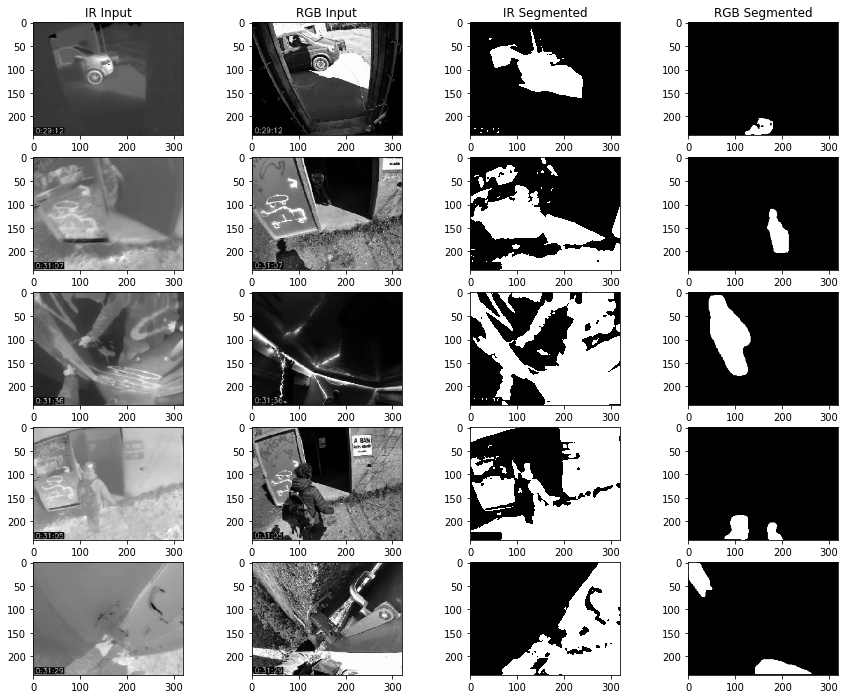

In [17]:
index = [35, 65, 48, 45, 251]

fig, ax = plt.subplots(len(index), 4, figsize=(15, 12))

for i in range(len(index)):
        j = index[i]
        ax[i][0].imshow(ir[j], cmap='gray') #moving_images: IR
        ax[0][0].set_title("IR Input")

        ax[i][1].imshow(vis[j], cmap='gray') #Fixed images: RGB
        ax[0][1].set_title("RGB Input")

        ax[i][2].imshow(ir_seg[j], cmap='gray') 
        ax[0][2].set_title("IR Segmented")

        ax[i][3].imshow(visible_seg[j], cmap='gray') 
        ax[0][3].set_title("RGB Segmented")    

In [14]:
#################################################
##			       Mask Generation 		       ##
#################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("############## Using GPU/CPU: {} ##############".format(device))

visible_seg = 255 - visible_seg 
ir_seg = 255 - ir_seg 

############## Using GPU/CPU: cpu ##############


In [15]:
#################################################
##			     Mask Registration 		       ##
#################################################
model = AffineNet().to(device)

def parseImages(imgs, size):
    imgsDimSup = torch.from_numpy(imgs).float()
    imgsDimSup = imgsDimSup[None, ...]
    imgsDimSup = imgsDimSup[:, :size, :, :]
    imgsDimSup = imgsDimSup.permute(1, 0, 2, 3)
    imgsDimSup = imgsDimSup/255
    return imgsDimSup

In [16]:
#beg = 50
#end = 1050
beg = 0
end = 2800
visible_seg_norm =  parseImages(visible_seg, end)
visible_seg_norm = visible_seg_norm[beg:end, ...]
visible_seg_norm = visible_seg_norm.to(device)

ir_seg_norm = parseImages(ir_seg, end)
ir_seg_norm = ir_seg_norm[beg:end, ...]
ir_seg_norm = ir_seg_norm.to(device)

In [17]:
print("\tir_seg_norm: ", ir_seg_norm.shape)
print("\tvisible_seg_norm: ", visible_seg_norm.shape)

	ir_seg_norm:  torch.Size([2800, 1, 240, 320])
	visible_seg_norm:  torch.Size([2800, 1, 240, 320])


In [18]:
print("############# Uploading Model    #######################")
#torch.save(model.state_dict(), "registration_videoARO2.ph")
video_name = "SAVE_2_AFI"
model_path = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/" + video_name+ "/registration_videoARO2.ph"
model.load_state_dict(torch.load(model_path))
model.eval()

############# Uploading Model    #######################


AffineNet(
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU(inplace=True)
    (15): Conv2d(80, 100, kernel_size=(3, 3), stride=(1, 1))
    (16): MaxPool2d(kernel_size=2, stride

In [19]:
#################################################
##			  Affine Interpolation 		       ##
#################################################
wrap, flow = model(ir_seg_norm[:100, ...].cpu())
print("\tFlow shape: ", flow.shape)
print("\tWrap shape: ", wrap.shape)

/Users/user/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/user/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


	Flow shape:  torch.Size([100, 240, 320, 2])
	Wrap shape:  torch.Size([100, 1, 240, 320])


In [20]:
print("\tFlow max: ", flow.max())
print("\tWrap max: ", wrap.max())

	Flow max:  tensor(0.9998, grad_fn=<MaxBackward1>)
	Wrap max:  tensor(1., grad_fn=<MaxBackward1>)


In [21]:
# Reshaping data
vis = torch.from_numpy(vis).float()
vis = vis[None, ...]
vis = vis.permute(1, 0, 2, 3)

ir = torch.from_numpy(ir).float()
ir = ir[None, ...]
ir = ir.permute(1, 0, 2, 3)

In [22]:
print("\tVIS shape: ", vis.size())
print("\tIR shape: ", ir.size())
print("\tVIS max: ", vis.max())
print("\tIR max: ", ir.max())

	VIS shape:  torch.Size([2828, 1, 240, 320])
	IR shape:  torch.Size([2828, 1, 240, 320])
	VIS max:  tensor(255.)
	IR max:  tensor(254.)


In [23]:
vis_norm = vis / 255
ir_norm = ir / 255

In [24]:
x = F.grid_sample(ir_norm[:100], flow)

print("\tX.shape: ", x.shape)
print("\tVIS: ", vis.shape)
print("\tIR: ", ir.shape)

	X.shape:  torch.Size([100, 1, 240, 320])
	VIS:  torch.Size([2828, 1, 240, 320])
	IR:  torch.Size([2828, 1, 240, 320])


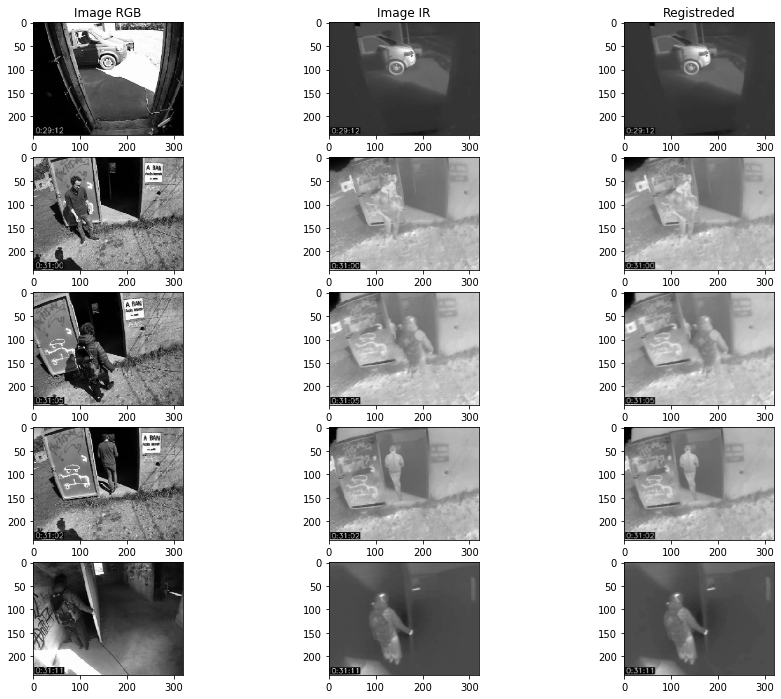

In [25]:
index = [2, 5, 48, 21, 95]

fig, ax = plt.subplots(len(index), 3, figsize=(15, 12))
for i in range(len(index)):
    j = index[i]
    ax[0][0].set_title("Image RGB")
    ax[0][1].set_title("Image IR")
    ax[0][2].set_title("Registreded")
    
    ax[i][0].imshow(vis[j, 0], cmap='gray')
    ax[i][1].imshow(ir[j, 0], cmap='gray')
    ax[i][2].imshow(x[j, 0].detach().numpy(), cmap='gray')
    #ax[i][2].imshow(x[j, 0], cmap='gray')

In [26]:
print("\tMax of Output Flow segmented: ", x.max())
print("\tMax of VISIBLE segmented: ", vis.max())

	Max of Output Flow segmented:  tensor(0.9842, grad_fn=<MaxBackward1>)
	Max of VISIBLE segmented:  tensor(255.)


In [27]:
x = x * 255
x = x.detach().numpy()
x = x.astype("uint8")

In [29]:
vis = vis.detach().numpy()
vis = vis.astype("uint8")
ir = ir.detach().numpy()
ir = ir.astype("uint8")

In [30]:
print("\tMax of Output Flow: ", x.max())
#print("\tMax of VISIBLE: ", fusion_vis.max())

print("\tShape of output Flow: ", x.shape)
#print("\tMax of VISIBLE: ", fusion_vis.shape)

	Max of Output Flow:  250
	Shape of output Flow:  (100, 1, 240, 320)


In [31]:
def registrated_frames(flow, path, size):
    for i in tqdm(range(1, flow[:size].shape[0])):
        name = "frame{}.jpg".format(i)
        path_new = path + "/" + name
        io.imsave(path_new, flow[i, 0])

In [32]:
#Saving
nom_video = "SAVE_2_visible_AFI"
path_registration = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Registred/Registration"

path_visible = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Registred/VISIBLE" 

In [33]:
registrated_frames(x, path_registration, 100)

100%|██████████| 99/99 [00:00<00:00, 239.14it/s]


In [34]:
registrated_frames(vis, path_visible, 100)

100%|██████████| 99/99 [00:00<00:00, 255.69it/s]


In [35]:
path_visible_rgb = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Registred/VISIBLE_RGB/" 

In [47]:
vis_rgb = dataload_rgb(path_vis2)

  0%|          | 5/2828 [00:00<00:57, 48.86it/s]

		Working with 2828 VISIBLE images
	############# Uploading images #############
	## Uploading /Volumes/IEMPROG/dataset/SAVE_2_visible_AFI ##


100%|██████████| 2828/2828 [00:46<00:00, 61.36it/s]


	############# All images to array ##########


In [48]:
vis_rgb = vis_rgb.astype("uint8")

In [20]:
def save_rgb(vis_imgs, path, size):
    for i in tqdm(range(1, vis_imgs[:size].shape[0])):
        name = "frame{}.jpg".format(i)
        path_new = path + "/" + name
        io.imsave(path_new, vis_imgs[i])

In [50]:
save_rgb(vis_rgb, path_visible_rgb, 100)

100%|██████████| 99/99 [00:00<00:00, 101.82it/s]


In [21]:
path_ir = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Registred/IR/" 
save_rgb(ir, path_ir, 100)

100%|██████████| 99/99 [00:00<00:00, 163.43it/s]
